In [1]:
from tensorflow.keras import backend as K
K.clear_session()  # Clears the Keras session to free up memory


In [2]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Resizing, Rescaling , RandomFlip , RandomRotation
from tensorflow.keras import Sequential
import numpy as np
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model


In [3]:
#constant values
IMAGE_SIZE= 256
BATCH_SIZE= 16
CHANNELS = 3 
EPOCHS = 10

In [4]:
# loading of Data / Images
# Image preprocessing 
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "data",
    shuffle=True,
    image_size= (IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE 
)

Found 3988 files belonging to 9 classes.


In [5]:
# Class Names or Labels Names
class_names = dataset.class_names
class_names

['Berry',
 'Fig',
 'Guava',
 'Orange',
 'Palm',
 'Persimmon',
 'Tomato',
 'apple',
 'grape']

In [6]:
#length of Dataset //  32*125 = 4000 / which approximately to our total number of images
len(dataset)

250

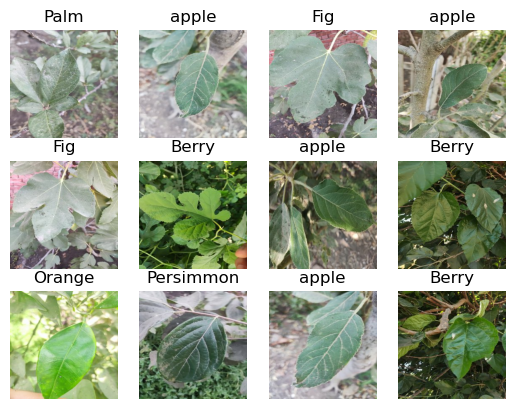

In [7]:
# randomly showing 12 images from the dataset 
for image_batch, label_batch in dataset.take(1):
   for i in range(12):
        ax= plt.subplot(3,4,i+1)# for printing in a matrics of 3*4
        plt.imshow(image_batch[i].numpy().astype("uint8"))# for printing image
        plt.title(class_names[label_batch[i]]) # for printing label name
        plt.axis("off")


In [8]:
#dividing the dataset for training , test and validation pourpose
#70% ==> training
#30% ==> 15% validation , 15% test

In [9]:
# for inatializing the lengthb of training data
train_size = 0.7
len(dataset)*train_size

175.0

In [10]:
test_ds = dataset.skip(175) 
len(test_ds)

75

In [11]:
# for inatializing the lengthb of validating data
val_size=0.15
len(dataset)*val_size

37.5

In [12]:
val_ds = test_ds.take(37)
len(val_ds)

37

In [13]:
test_ds = test_ds.skip(37)
len(test_ds)


38

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.15, shuffle= True, shuffle_size=10000):
    
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size= int(train_split*ds_size)
    val_size= int(val_split*ds_size)

    train_ds= ds.take(train_size)

    val_ds= ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [15]:
import tensorflow as tf

def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.15, shuffle=True, shuffle_size=10000):
    # Get the size of the dataset
    ds_size = tf.data.experimental.cardinality(ds).numpy()
    if shuffle:
        ds = ds.shuffle(buffer_size=min(ds_size, shuffle_size), seed=12)

    # Calculate split sizes
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    # Create partitions
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds


In [16]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

175

In [18]:
len(val_ds)

37

In [19]:
len(test_ds)

38

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:

resize_and_rescale = Sequential([
    Resizing(IMAGE_SIZE, IMAGE_SIZE),
    Rescaling(1.0 / 255)
])


In [22]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
])

In [23]:
# Define the model again without calling model.build() or using dummy input
#input_shape = (BATCH_SIZE , IMAGE_SIZE , IMAGE_SIZE, CHANNELS)
n_classes = 9


import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model




base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

base_model.trainable =True


x = base_model.output
x = GlobalAveragePooling2D()(x)  
x = Dense(128, activation='relu')(x) 
output = Dense(n_classes, activation='softmax')(x)  


model= Model(inputs=base_model.input, outputs=output)


model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 262,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 128,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 128,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 128,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 130,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 64,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 64,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 64,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 64,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 64,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 64,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 64,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 64,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 64,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 64,    │      1,024 │ conv2_block1_3_c

 Total params: 23,851,145 (90.98 MB)

 Trainable params: 23,798,025 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [24]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Use a low learning rate
    loss='categorical_crossentropy',  # For multi-class classification
    metrics=['accuracy']  # Track accuracy during training
)


In [26]:
history = model.fit(
    train_ds,  # Training dataset
    validation_data=val_ds,  # Validation dataset
    epochs=10,  # Number of epochs for fine-tuning
    verbose=1  # Show progress during training
)


Epoch 1/10


ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 9)

In [ ]:
#print("Using layer:", last_conv_layer_name)

In [ ]:
scores=model.evaluate(test_ds)

In [ ]:
scores

In [ ]:
history

In [ ]:
history.params

In [ ]:
history.history.keys()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:

plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label= ' Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label= ' Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy') 
plt.show()
plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),loss,label= ' Training Loss')
plt.plot(range(EPOCHS),val_loss,label= ' Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss') 
plt.show()

In [ ]:
for images_batch, labels_batch in test_ds.take(1):
   
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("first image's actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("Predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) 

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100* (np.max(predictions[0])),2)
    return predicted_class,confidence 

In [ ]:
plt.figure(figsize=(20,15))
for images, labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual:{actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off") 

In [ ]:
import numpy as np

y_true = []  # To store the true labels
y_pred = []  # To store the predicted labels

for images, labels in test_ds:
    # Check if labels are one-hot encoded (2D array) or class indices (1D array)
    if len(labels.shape) > 1:  # If labels are one-hot encoded
        y_true.extend(np.argmax(labels.numpy(), axis=1))
    else:  # If labels are already class indices
        y_true.extend(labels.numpy())
    
    # Predict with the model
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)  # Convert probabilities to class index
    y_pred.extend(predicted_classes)

# Convert lists to numpy arrays (optional, for compatibility)
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Now you can use y_true and y_pred for evaluation
from sklearn.metrics import classification_report, confusion_matrix

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))
